# Poisson vs. gaussian regression
> How do the two models compare in terms of accuracy at different read counts?

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from src.simulation_new import make_tables
from src.database import RnaDB
from src.torch_solver import TorchSolver

In [3]:
rnadb = RnaDB(
    path_to_dnaA = "../../data/allDnaA.tsv",
    path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [4]:
# Copied from scaling_experiment_matrix.ipynb

def score(solver, true_abundances, true_log2_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.B_hat.exp2().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp2(true_log2_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances


In [24]:
results = pd.DataFrame()
losses = [torch.nn.MSELoss(), torch.nn.PoissonNLLLoss(log_input=False)]
for multiplier in range(-3, 3):
    scale = 10**multiplier
    print(scale)
    abundances, log2_ptrs, otus = make_tables(
        n_genomes=10,
        n_samples=20,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=scale,
    )
    for loss_fn, normalize in zip(losses, [True, False]):
        solver = TorchSolver(otus=otus, db=rnadb, normalize=normalize)
        solver.train(lr=0.1, clip=True, model_bias=False, loss_fn=loss_fn)
        B_scores, A_scores, B_inf, A_inf = score(
            solver=solver,
            true_log2_ptrs=log2_ptrs,
            true_abundances=abundances,
        )
        for i, genome_id in enumerate(solver.genome_ids):
            for j, sample_id in enumerate(solver.sample_ids):
                try:
                    results = results.append(
                        {
                            "loss_fn": loss_fn,
                            "genome": genome_id,
                            "sample": sample_id,
                            "scale": scale,
                            "true_ptr": np.exp2(
                                log2_ptrs.loc[genome_id, sample_id]
                            ),
                            "inferred_ptr": B_inf.loc[genome_id, sample_id],
                            "inferred_abundance": A_inf.loc[
                                genome_id, sample_id
                            ],
                            "abundance": abundances.loc[genome_id, sample_id],
                            "ptr_score": B_scores.loc[genome_id, sample_id],
                            "abundance_score": A_scores.loc[
                                genome_id, sample_id
                            ],
                            "n_reads": otus.loc[
                                rnadb[genome_id]["md5"].unique(), sample_id
                            ].sum(),
                        },
                        ignore_index=True,
                    )
                except KeyError as e:
                    print(f"=====KEY ERROR: {e}")


0.001
Using OTU index for md5s
Initial:	 5.273308277130127
Epoch 0:	 0.0006794622167944908
Epoch 1:	 0.0006794618093408644
Epoch 2:	 0.0006794628570787609
Epoch 3:	 0.0006794619257561862
Epoch 4:	 0.0006794764776714146
Epoch 5:	 0.0006794632063247263
Epoch 6:	 0.000679466815199703
Epoch 7:	 0.0006794725777581334
Using OTU index for md5s
Initial:	 1.1329582929611206
Epoch 0:	 0.12570638954639435
Epoch 1:	 0.12570667266845703
Epoch 2:	 0.1257084459066391
Epoch 3:	 0.1257166862487793
Epoch 4:	 0.12572717666625977
Epoch 5:	 0.12572641670703888
Epoch 6:	 0.15355531871318817
0.01
Using OTU index for md5s
Initial:	 15.979619026184082
Epoch 0:	 3.7015452107880265e-05
Epoch 1:	 3.701360401464626e-05
Epoch 2:	 3.701349123730324e-05
Epoch 3:	 3.701309469761327e-05
Epoch 4:	 3.7033751141279936e-05
Epoch 5:	 3.7038731534266844e-05
Epoch 6:	 3.705707786139101e-05
Epoch 7:	 3.702067624544725e-05
Epoch 8:	 3.701658715726808e-05
Epoch 9:	 3.7015288398833945e-05
Using OTU index for md5s
Initial:	 -16.02

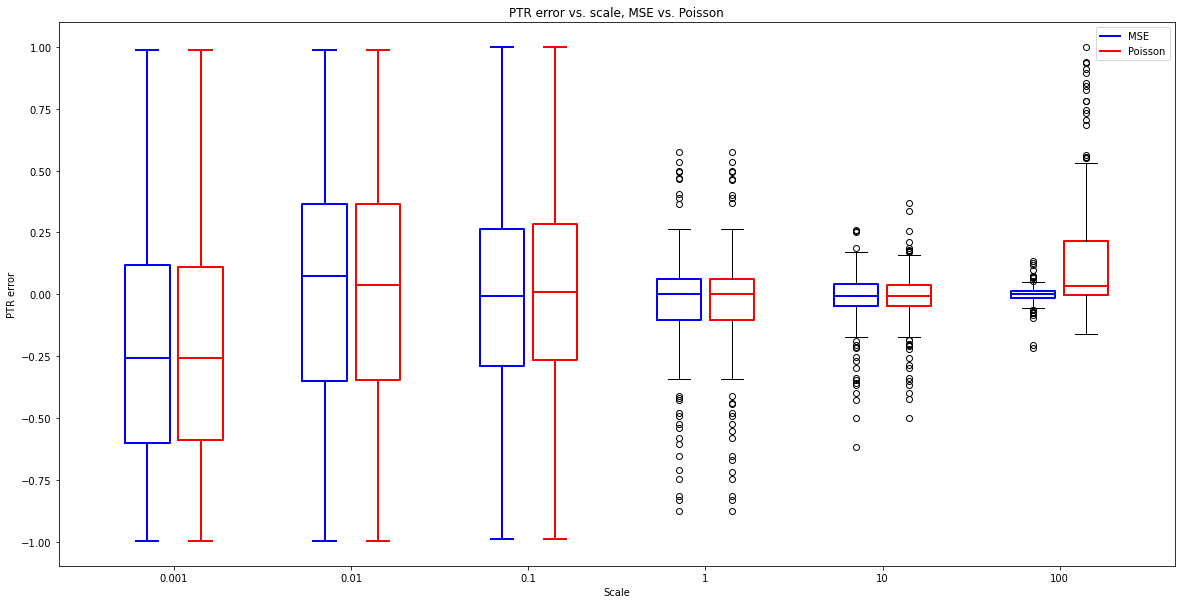

In [49]:
fig = plt.figure(figsize=(20, 10))

# Make data
for_boxplot_mse = results[results["loss_fn"] == losses[0]]
for_boxplot_poisson = results[results["loss_fn"] == losses[1]]
x1 = [for_boxplot_mse[for_boxplot_mse["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_poisson[for_boxplot_poisson["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = plt.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = plt.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
plt.xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
plt.xlabel("Scale")
plt.ylabel("PTR error")
plt.title("PTR error vs. scale, MSE vs. Poisson")

# Change colors for medians
for b, c in zip([bp1, bp2], ["blue", "red"]):
    for median, box, cap, line in zip(
        b["medians"], b["boxes"], b["caps"], b["whiskers"]
    ):
        median.set(color=c, linewidth=2)
        box.set(color=c, linewidth=2)
        cap.set(color=c, linewidth=2)
        line.set(color=c, linewidth=2)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["MSE", "Poisson"])


[]

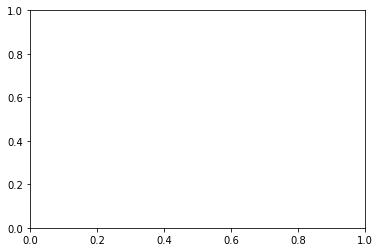

In [39]:
plt.gca().artists